In [1]:
import sys
import math
import anndata

#if branch is stable, will install via pypi, else will install from source
branch = "stable"
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB and branch == "stable":
    !pip install --quiet scvi-tools[tutorials]
elif IN_COLAB and branch != "stable":
    !pip install --quiet --upgrade jsonschema
    !pip install --quiet git+https://github.com/yoseflab/scvi-tools@$branch#egg=scvi-tools[tutorials]

In [2]:
def Barplot(which_var, adata, var='clusters', height=3, color = False):
    plotdata = pd.crosstab(adata.obs[var], adata.obs[which_var], normalize='index') * 100
    if 'category' in plotdata.index.dtype.name:
        plotdata.index.reorder_categories(adata.obs[var].cat.categories[::-1])

    if not color:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (6,height), fontsize = 14, grid = False)
    else:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (6,height), fontsize = 14, grid = False, color = color)
    ax1.set_title(which_var+' %')
    ax1.set_ylabel(var)
    horiz_offset = 1
    vert_offset = 1.
    ax1 = ax1.legend(bbox_to_anchor = (horiz_offset, vert_offset))
#     ax1.figure.savefig('barplot_'+var+'_proportions_'+which_var+'.pdf', bbox_inches='tight',
#                        dpi=300, orientation='landscape', format= 'pdf', optimize=True)

In [3]:
 palette = ["#E31A1C", "#1F78B4", "#A6CEE3",  "#B2DF8A", "#33A02C", "#FB9A99",  "#FDBF6F", "#FF7F00", "#CAB2D6", "#6A3D9A", "#FFFF99", "#B15928", "#66C2A5",
               "#FC8D62", "#8DA0CB", "#B3B3B3", "#A6D854", "#FFD92F", "#E5C494", "#E78AC3"]

#### Set up scVI environment

In [4]:
import scvi
import scanpy as sc

sc.set_figure_params(figsize=(4, 4))

OMP: Info #270: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [5]:
import pandas as pd 
import numpy as np

# Somatic early

### Read in sanger dataset

In [6]:
path_to_gonads = '/nfs/team292/lg18/with_valentina/gonadsV2_revision/'
sanger = sc.read(path_to_gonads + 'mouse-gonads_rawcounts.h5ad')

### Load Niu dataset

In [7]:
niu = sc.read('/nfs/team292/vl6/Mouse_Niu2020/mouse_annotated.h5ad')
niu = anndata.AnnData(X=niu.raw.X, var=niu.raw.var, obs=niu.obs, asview=False)

## Merge datasets

In [8]:
sanger.obs['dataset'] = 'Sanger'
niu.obs['dataset'] = 'Niu2020'
niu.obs['sex'] = 'female'
niu.obs['location'] = 'gonad'
adata = sanger.concatenate(niu,
                    batch_key = 'dataset', 
                batch_categories = ['Sanger', 'Niu2020'], 
                                  join = 'outer')

## Subset cells

In [9]:
# Add old cluster subname
metaF = pd.read_csv(path_to_gonads+'/mouse_females_scVIintegrated_annotated.csv')
metaF = metaF.set_index('Unnamed: 0')
metaF.head()

metaM = pd.read_csv(path_to_gonads+'/mouse_males_scVIintegrated_annotated.csv')
metaM = metaM.set_index('Unnamed: 0')
metaM.index = [i+"-Sanger" for i in metaM.index]
metaM.head()


cell_annotM = metaM['lineage'].to_dict()
cell_annotF = metaF['lineage'].to_dict()
cell_annot = {**cell_annotM , **cell_annotF}
adata.obs['lineage'] = adata.obs_names.map(cell_annot).astype('category')

/opt/conda/envs/scvi-singularity/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (11,18,20) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [10]:
adata.obs['lineage'].values.describe()

counts     freqs
categories                          
CoelEpi_Gata2         5258  0.048838
CoelEpi_Lhx9          8267  0.076787
Endothelial           2210  0.020527
Epithelial            7966  0.073992
Epithelial_Wnt7a      1222  0.011350
Erythroid             1273  0.011824
FetalLeydig            184  0.001709
GermCells             6207  0.057653
Immune                1287  0.011954
Mesenchymal_Crabp1   12262  0.113895
Mesenchymal_Gata2    14851  0.137942
Mesenchymal_Lhx9     15441  0.143422
Neural                1971  0.018307
PV                     940  0.008731
SMCs                   827  0.007682
Sertoli               1493  0.013868
Supporting           20294  0.188499
cont                  4210  0.039104
lowQC                 1498  0.013914

In [11]:
adata = adata[[i in ['10.5', '11.5', "E11.5"] for i in adata.obs.stage ]]
adata = adata[[i in ['Supporting', 'Sertoli', 'CoelEpi_Lhx9', 'Mesenchymal_Lhx9', 'FetalLeydig'] for i in adata.obs.lineage]]
adata.obs['lineage'].values.describe()

counts     freqs
categories                        
CoelEpi_Lhx9        4589  0.440234
Mesenchymal_Lhx9    1885  0.180833
Sertoli              470  0.045088
Supporting          3480  0.333845

In [12]:
# Add old cluster subname
metaF = pd.read_csv(path_to_gonads+'/mouse-gonads_scVI_somatic_annotation.csv')
metaF = metaF.set_index('Unnamed: 0')
metaF.head()

cell_annot = metaF['celltype'].to_dict()
adata.obs['celltype'] = adata.obs_names.map(cell_annot).astype('category')

Trying to set attribute `.obs` of view, copying.


In [13]:
sc.pp.filter_genes(adata, min_counts=3)

### OPTIONAL - Remove cc genes

In [14]:
# ccgs defined in M1
adata = adata[:,[i not in sanger.uns['ccgs'] for i in adata.var_names]]
print('Total number of genes after ccg filter: {:d}'.format(adata.n_vars))

Total number of genes after ccg filter: 21428


### Identify HVGs

!!! Unlike before (at least I think), now they recommend subsetting to highly variable genes before running scVI 

--> the tutorial says anywhere in between 1000 and 10,000 should be fine, so I arbitrarily chose 2000

In [15]:
# sc.pp.highly_variable_genes(
#     adata,
#     n_top_genes=2000,
#     subset=False,
#     flavor="seurat_v3"
# )
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=1000,
    subset=False,
    flavor="seurat_v3",
    batch_key='stage'
)

/opt/conda/envs/scvi-singularity/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:144: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[: int(n_top_genes), 'highly_variable'] = True
Trying to set attribute `.uns` of view, copying.


In [16]:
# subset object for scVI
bdata = adata[:, adata.var['highly_variable']]
bdata.layers["counts"] = bdata.X.copy() # preserve counts

In [17]:
'Sry' in bdata.var_names

False

In [18]:
'Foxl2' in bdata.var_names

True

## Normalize - optional

In [19]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

## scVI

!!! Here you can specify your covariates you want to correct for

In [20]:
scvi.data.setup_anndata(
    bdata,
    layer="counts",
    batch_key='dataset',
    categorical_covariate_keys=["stage"] 
#     continuous_covariate_keys=["percent_mito"]#
)

INFO     Using batches from adata.obs["dataset"]                                             
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 10424 cells, 1000 vars, 2 batches,
         1 labels, and 0 proteins. Also registered 1 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


In [21]:
model = scvi.model.SCVI(bdata, n_latent= 10)
# model = scvi.model.SCVI(bdata, n_latent= 60)

In [22]:
model

SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, 
gene_likelihood: zinb, latent_distribution: normal
Training status: Not Trained

To print summary of associated AnnData, use: scvi.data.view_anndata_setup(model.adata)

In [23]:
model.train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [1:16:30<00:00, 11.48s/it, loss=774, v_num=1]


In [24]:
latent = model.get_latent_representation()

In [25]:
adata.obsm["X_scVI"] = latent

### Save latent space

In [73]:
pd.DataFrame(adata.obsm["X_scVI"]).to_csv(path_to_gonads+'/mouse-gonads_XscVI_latent_somaticEarly.csv')
pd.DataFrame(adata.obs).to_csv(path_to_gonads+'/mouse-gonads_XscVI_latentMeta_somaticEarly.csv')

### Visualization and Clustering

In [27]:
# use scVI latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="X_scVI", n_neighbors=50)
sc.tl.umap(adata, min_dist=0.4)

... storing 'sample' as categorical
... storing 'stage' as categorical
... storing 'sex' as categorical
... storing 'location' as categorical
... storing 'batch' as categorical
... storing 'phase' as categorical
... storing 'scmap_fromHuman' as categorical
... storing 'tissue' as categorical
... storing 'leiden' as categorical
... storing 'cell_type' as categorical


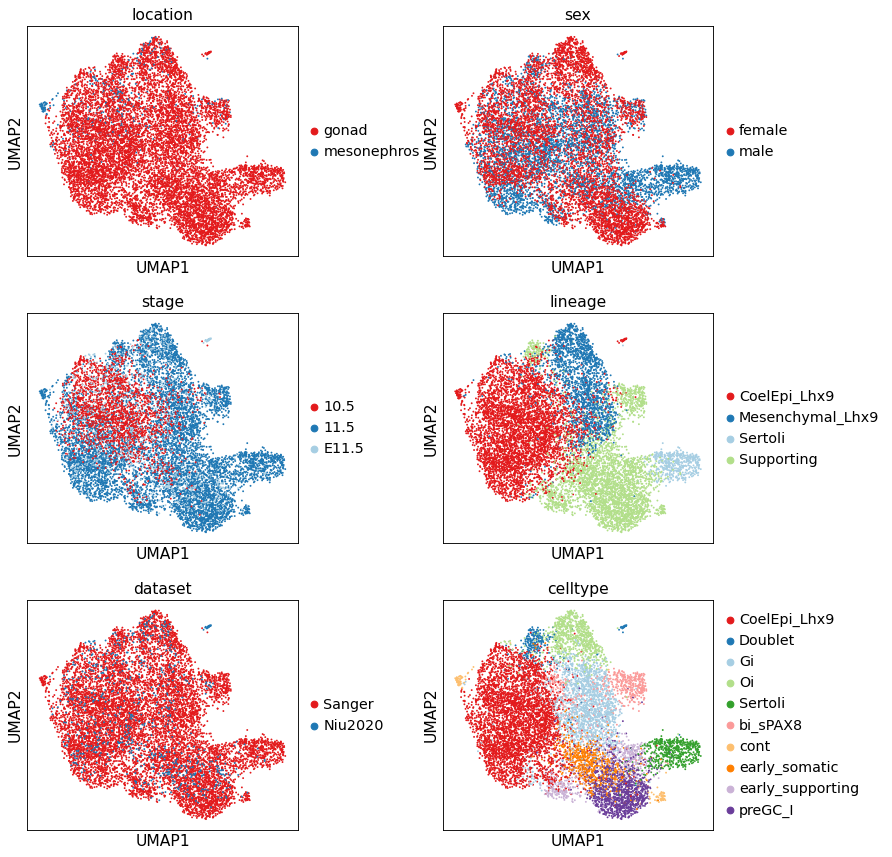

In [28]:
sc.pl.umap(
    adata,
    color=[ "location",  'sex', 'stage', "lineage", 'dataset', 'celltype'], 
    palette = palette,
    frameon=True, ncols = 2, wspace = 0.4
)

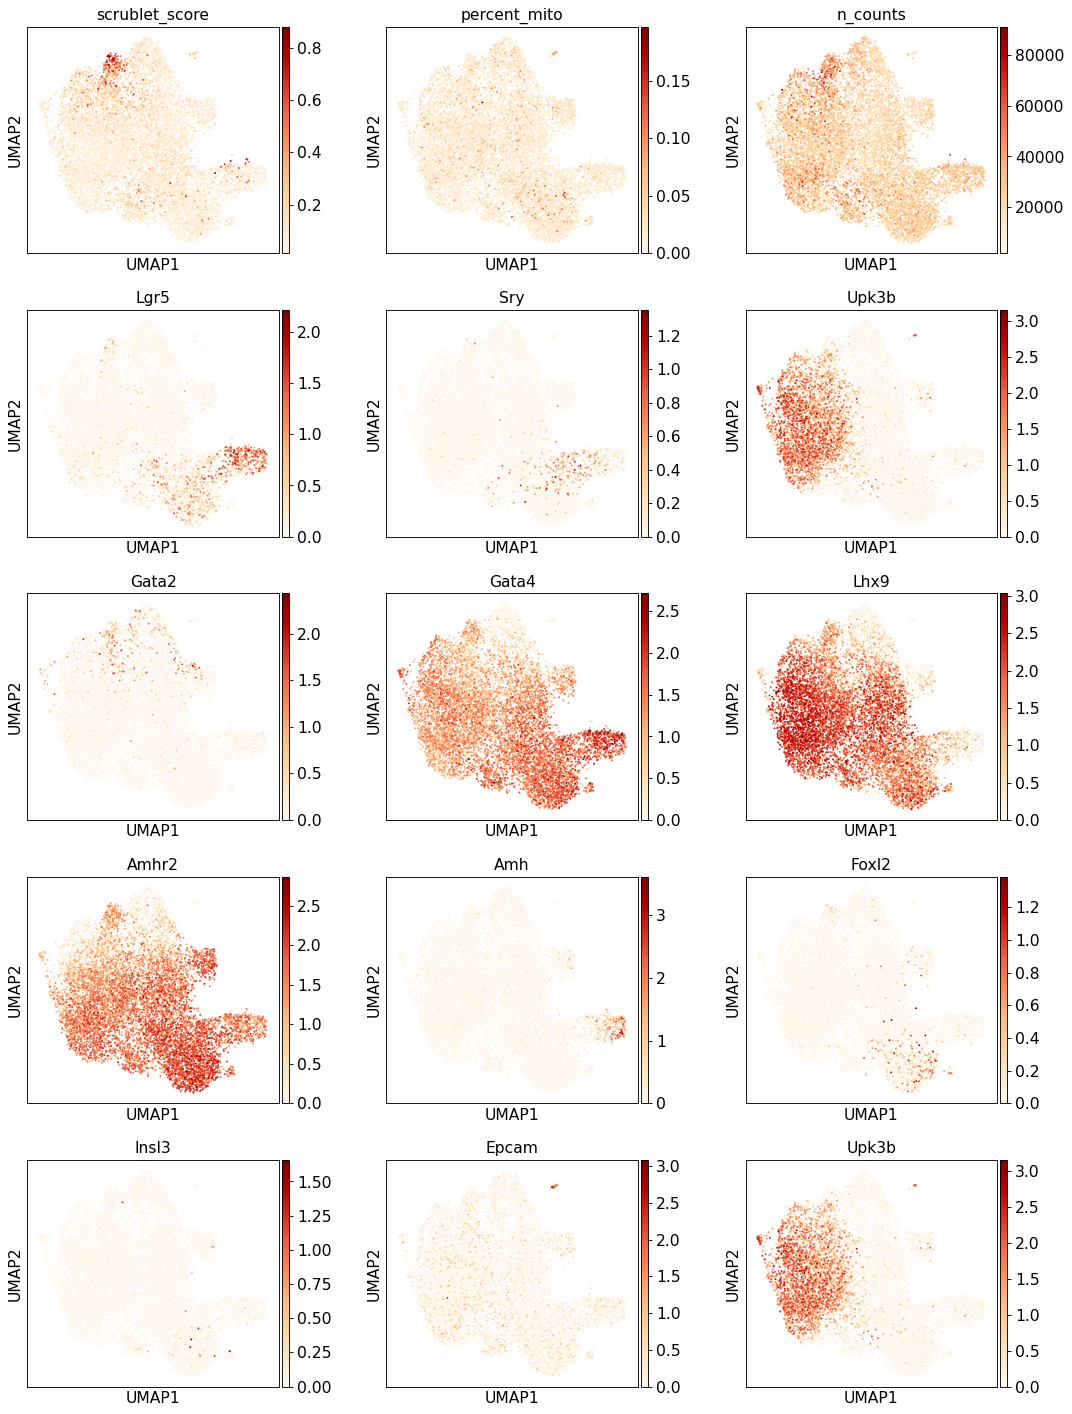

In [77]:
sc.pl.umap(
    adata,
    color=['scrublet_score',  'percent_mito', 'n_counts', 'Lgr5', 'Sry', 'Upk3b','Gata2', 'Gata4', 'Lhx9',  'Amhr2', 'Amh', 'Foxl2',  'Insl3', 'Epcam', 'Upk3b'], color_map = "OrRd",
    frameon=True, ncols = 3, wspace = 0.3
)

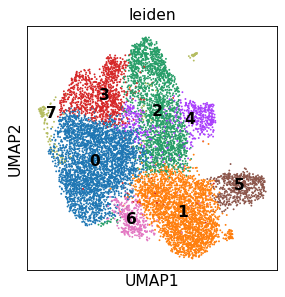

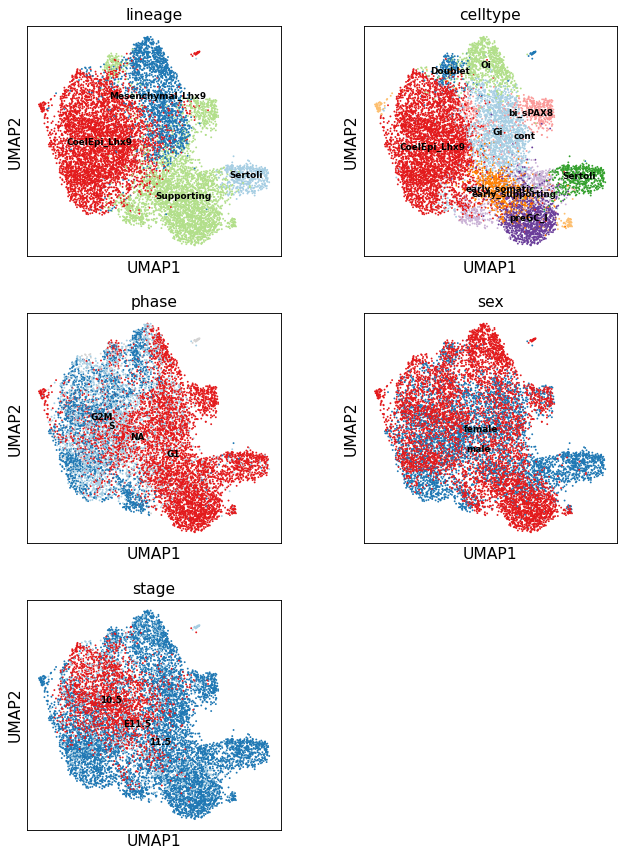

In [33]:
sc.tl.leiden(adata, resolution=0.5)
sc.pl.umap(
    adata,
    color=['leiden'], color_map = "OrRd",legend_loc='on data',
    frameon=True, ncols = 2, wspace = 0.3
)
sc.pl.umap(
    adata,
    color=['lineage', 'celltype','phase', 'sex', 'stage'], ncols = 2,
    palette = palette,legend_loc='on data', legend_fontsize=8
)

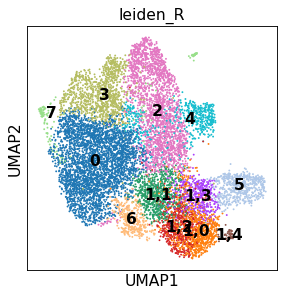

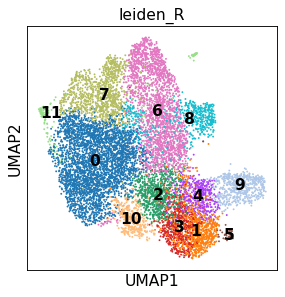

In [40]:
sc.tl.leiden(adata, resolution=0.55, restrict_to=('leiden', ['1']))
sc.pl.umap(adata, color='leiden_R',legend_loc='on data')
adata.obs['leiden_R'].cat.categories = [str(i) for i in range(len(adata.obs['leiden_R'].cat.categories))]
sc.pl.umap(adata, color='leiden_R',legend_loc='on data')
adata.obs['leiden'] = adata.obs['leiden_R']

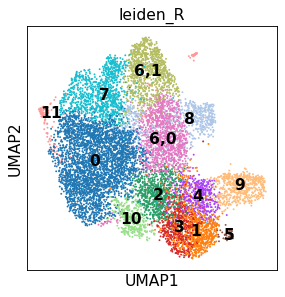

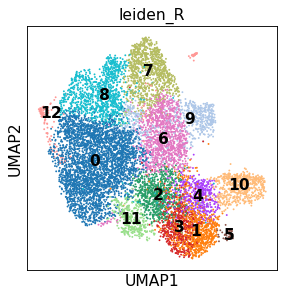

In [46]:
sc.tl.leiden(adata, resolution=0.15, restrict_to=('leiden', ['6']))
sc.pl.umap(adata, color='leiden_R',legend_loc='on data')
adata.obs['leiden_R'].cat.categories = [str(i) for i in range(len(adata.obs['leiden_R'].cat.categories))]
sc.pl.umap(adata, color='leiden_R',legend_loc='on data')
adata.obs['leiden'] = adata.obs['leiden_R']

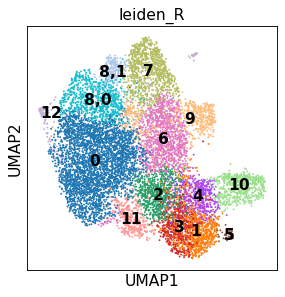

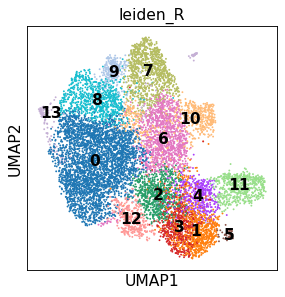

In [62]:
sc.tl.leiden(adata, resolution=0.22, restrict_to=('leiden', ['8']))
sc.pl.umap(adata, color='leiden_R',legend_loc='on data')
adata.obs['leiden_R'].cat.categories = [str(i) for i in range(len(adata.obs['leiden_R'].cat.categories))]
sc.pl.umap(adata, color='leiden_R',legend_loc='on data')
adata.obs['leiden'] = adata.obs['leiden_R']

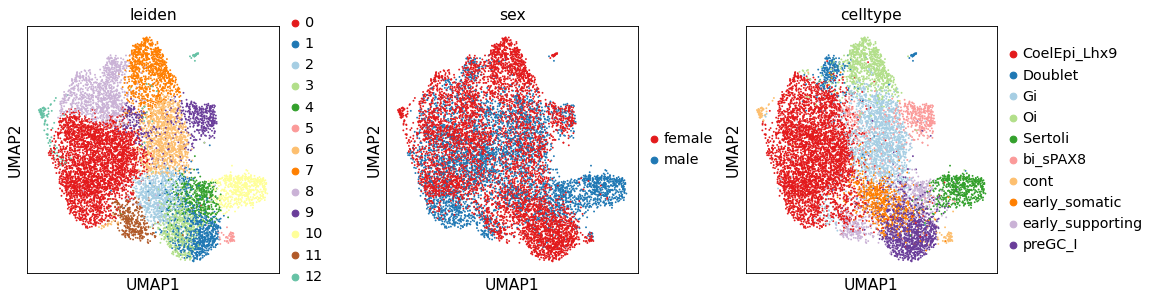

In [47]:
sc.pl.umap(
    adata,
    color=[ "leiden",  'sex', 'celltype'], 
    palette = palette,
    frameon=True, ncols = 3, wspace = 0.3
)

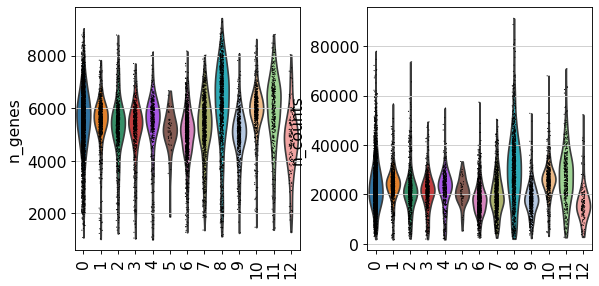

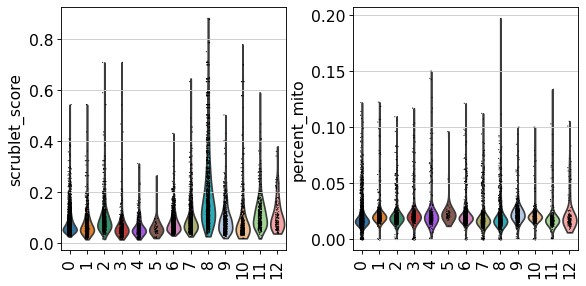

In [48]:
sc.pl.violin(adata, ['n_genes', 'n_counts'], groupby='leiden_R', rotation=90)
sc.pl.violin(adata, ['scrublet_score', 'percent_mito'], groupby='leiden_R', rotation=90)

## Markers

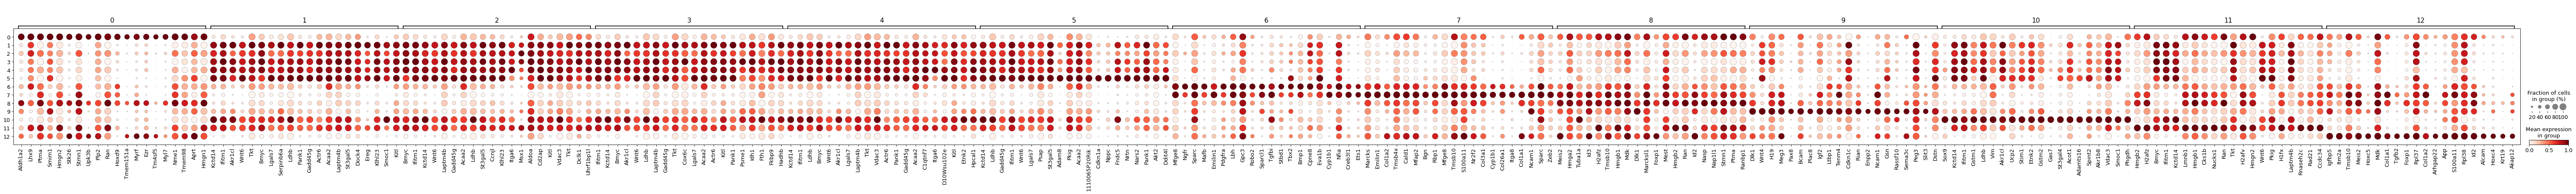

In [49]:
# sc.pp.scale(adata)
sc.tl.rank_genes_groups(adata, groupby='leiden', use_raw=False) #, method='logreg'
sc.pl.rank_genes_groups_dotplot(adata, n_genes=20, dendrogram=False, use_raw = False, standard_scale = 'var')

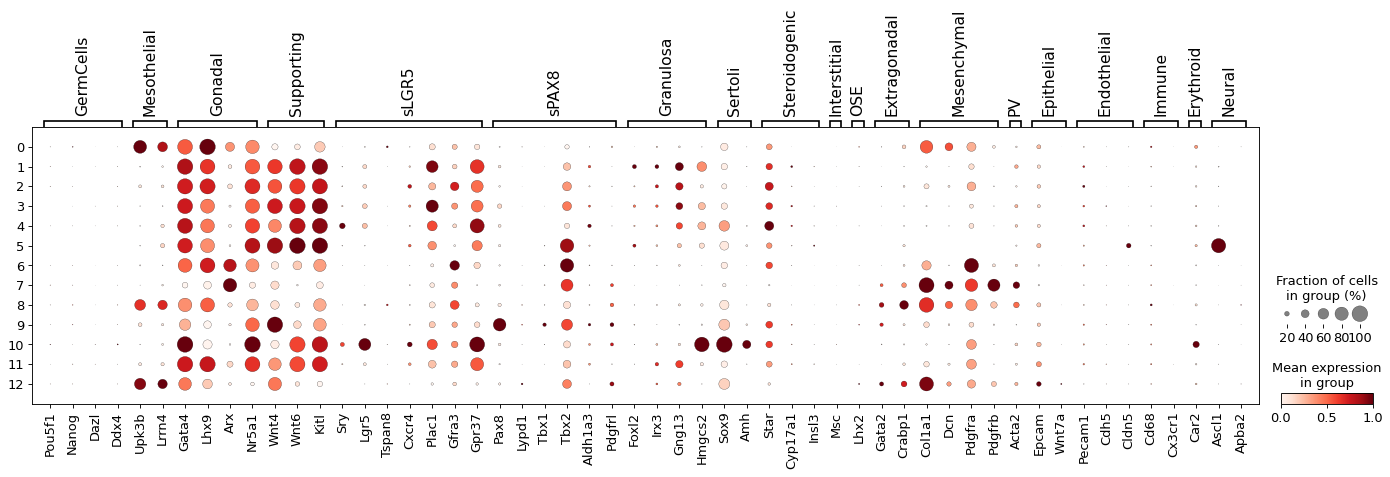

In [50]:
marker_genes = {'GermCells' : ['Pou5f1', 'Nanog', 'Dazl', 'Ddx4'], 
'Mesothelial' : ['Upk3b', 'Lrrn4'], 
'Gonadal' : ["Gata4", "Lhx9", 'Arx', 'Nr5a1'], 
'Supporting' : ['Wnt4',  'Wnt6',  'Kitl'], 
 'sLGR5' : ['Sry', 'Lgr5', 'Tspan8', 'Cxcr4', 'Plac1', "Gfra3",'Gpr37'],
 'sPAX8' : ['Pax8', 'Lypd1', 'Tbx1', 'Tbx2', 'Aldh1a3', 'Pdgfrl'], 
'Granulosa' : [ 'Foxl2', 'Irx3', 'Gng13','Hmgcs2'], 
 'Sertoli':['Sox9', 'Amh'],
 'Steroidogenic' : ['Star', 'Cyp17a1', 'Insl3'],
 'Interstitial' : ['Msc'],
 'OSE':['Lhx2'],
 'Extragonadal' : ['Gata2',   'Crabp1'], 
 'Mesenchymal' : ['Col1a1', 'Dcn', 'Pdgfra', 'Pdgfrb'],
 'PV':['Acta2'], 
 'Epithelial' : ['Epcam', 'Wnt7a'], 
 'Endothelial' : ['Pecam1', 'Cdh5', 'Cldn5'],
 'Immune' : ['Cd68', 'Cx3cr1'], 
 'Erythroid' : ['Car2'], 
 'Neural' : ['Ascl1', 'Apba2']
}
sc.pl.dotplot(adata, marker_genes, groupby='leiden', use_raw=False, standard_scale = 'var')

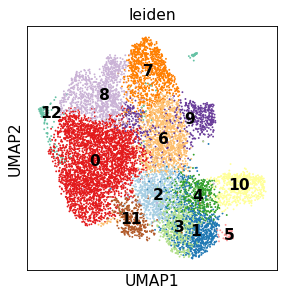

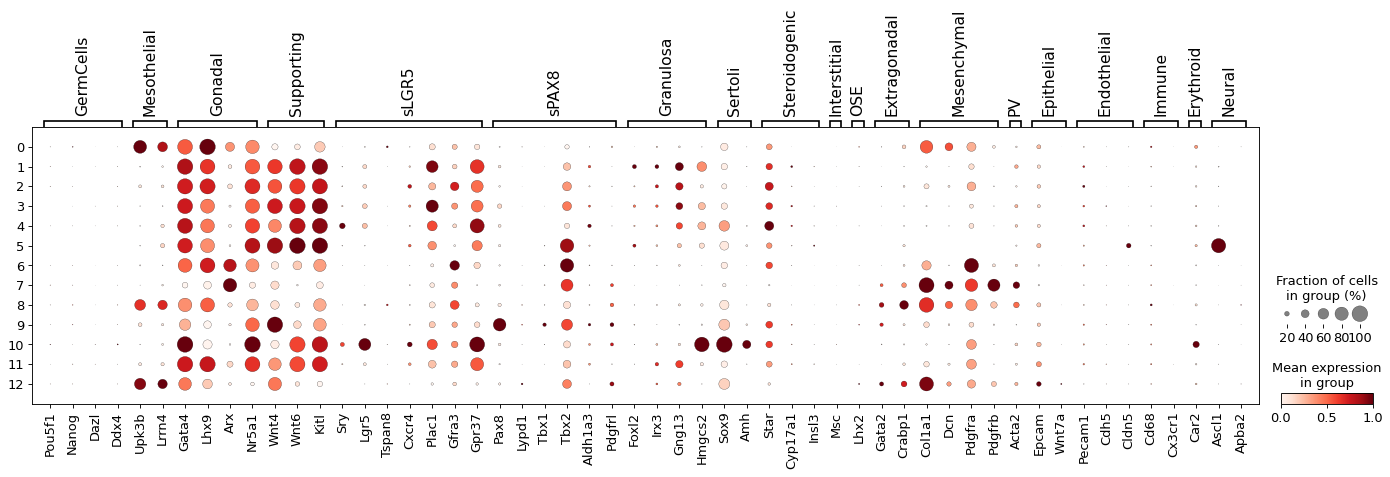

In [51]:
sc.pl.umap(adata, color='leiden',legend_loc='on data')
sc.pl.dotplot(adata, marker_genes, groupby='leiden', standard_scale = 'var')

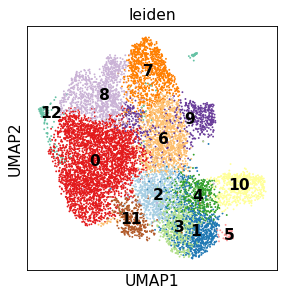

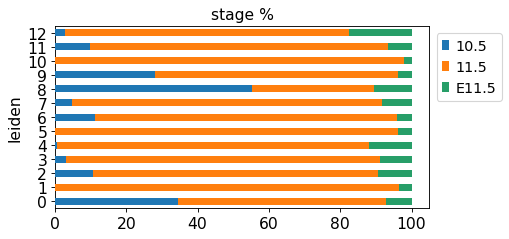

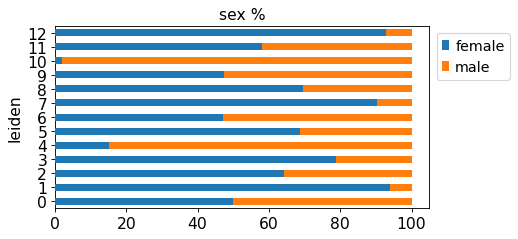

In [52]:
sc.pl.umap(adata, color='leiden',legend_loc='on data')
Barplot('stage', adata, var='leiden', height=3)
Barplot('sex', adata, var='leiden', height=3)

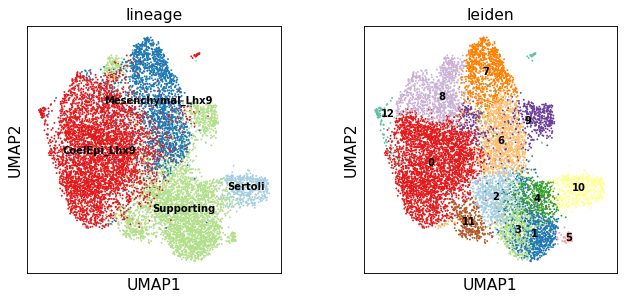

In [53]:
sc.pl.umap(
    adata,
    color=["lineage", 'leiden'], ncols = 2,
    palette = palette,legend_loc='on data', legend_fontsize=9
)

... storing 'celltype' as categorical


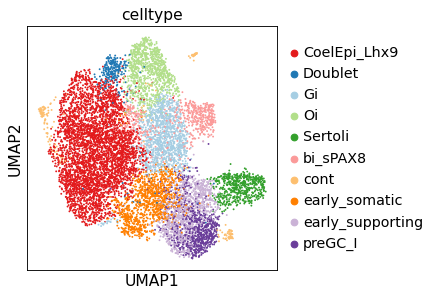

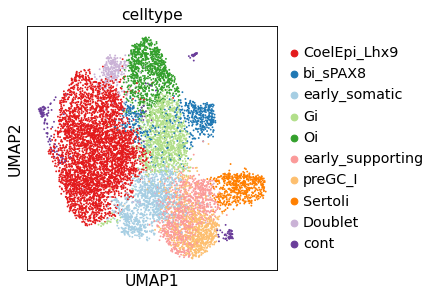

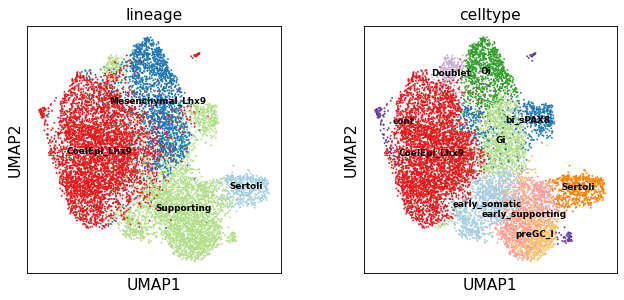

In [63]:
adata.obs['celltype'] = adata.obs['leiden'].tolist()
adata.obs.at[adata.obs['leiden'] == '0', 'celltype'] = 'CoelEpi_Lhx9'
adata.obs.at[adata.obs['leiden'] == '1', 'celltype'] = 'preGC_I'
adata.obs.at[adata.obs['leiden'] == '2', 'celltype'] = 'early_somatic'
adata.obs.at[adata.obs['leiden'] == '3', 'celltype'] = 'early_supporting'
adata.obs.at[adata.obs['leiden'] == '4', 'celltype'] = 'early_supporting'
adata.obs.at[adata.obs['leiden'] == '5', 'celltype'] = 'cont'
adata.obs.at[adata.obs['leiden'] == '6', 'celltype'] = 'Gi'
adata.obs.at[adata.obs['leiden'] == '7', 'celltype'] = 'Oi'
adata.obs.at[adata.obs['leiden'] == '8', 'celltype'] = 'CoelEpi_Lhx9'
adata.obs.at[adata.obs['leiden'] == '9', 'celltype'] = 'Doublet'
adata.obs.at[adata.obs['leiden'] == '10', 'celltype'] = 'bi_sPAX8'
adata.obs.at[adata.obs['leiden'] == '11', 'celltype'] = 'Sertoli'
adata.obs.at[adata.obs['leiden'] == '12', 'celltype'] = 'early_somatic'
adata.obs.at[adata.obs['leiden'] == '13', 'celltype'] = 'cont'
set(adata.obs['celltype'])
sc.pl.umap(adata, color=['celltype'])
adata.obs['celltype'].cat.reorder_categories(['CoelEpi_Lhx9',   'bi_sPAX8', 
                                             'early_somatic',  'Gi', 'Oi', 'early_supporting', 
                                              'preGC_I',  'Sertoli',
                                               'Doublet', 'cont'], inplace=True)

sc.pl.umap(adata, color=['celltype'])
sc.pl.umap(adata, color=['lineage', 'celltype'], ncols = 2, legend_loc='on data', legend_fontsize=8)

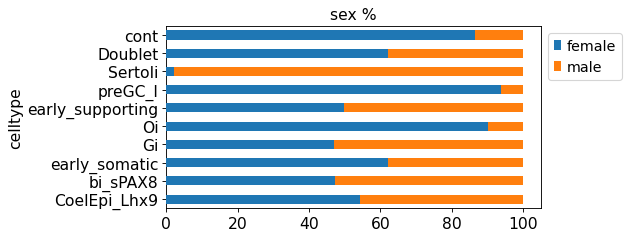

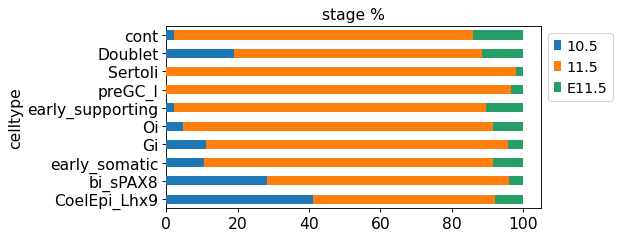

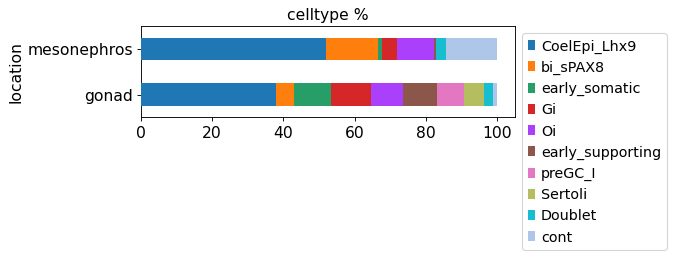

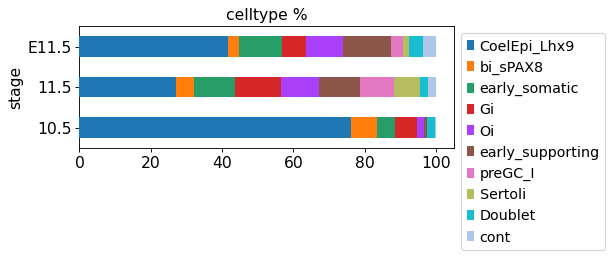

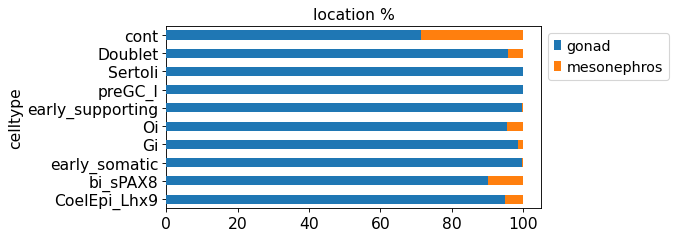

In [64]:
Barplot('sex', adata, var='celltype', height=3)
Barplot('stage', adata, var='celltype', height=3)
Barplot('celltype', adata, var='location', height=1.5)
Barplot('celltype', adata, var='stage', height=2)
Barplot('location', adata, var='celltype', height=3)

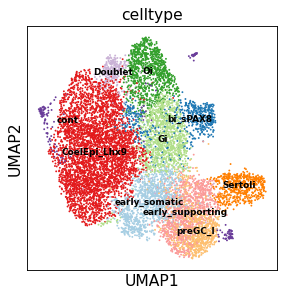

In [65]:
# del adata.uns['celltype_v1_colors']
# adata = adata[[i not in ['lowQC'] for i in adata.obs.celltype]]
sc.pl.umap(adata, color=['celltype'], ncols = 2, legend_loc='on data', legend_fontsize=8, palette=palette)

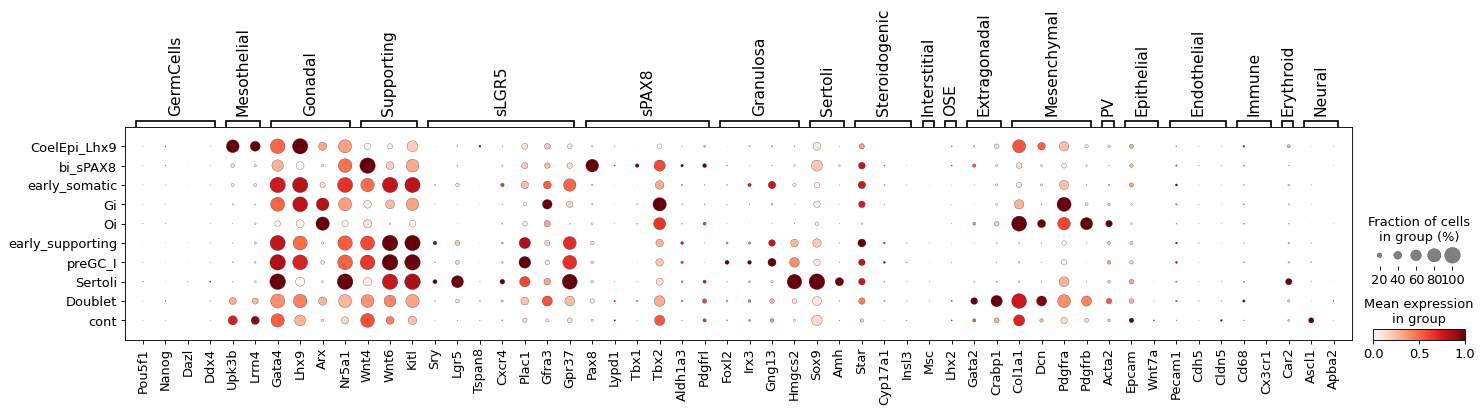

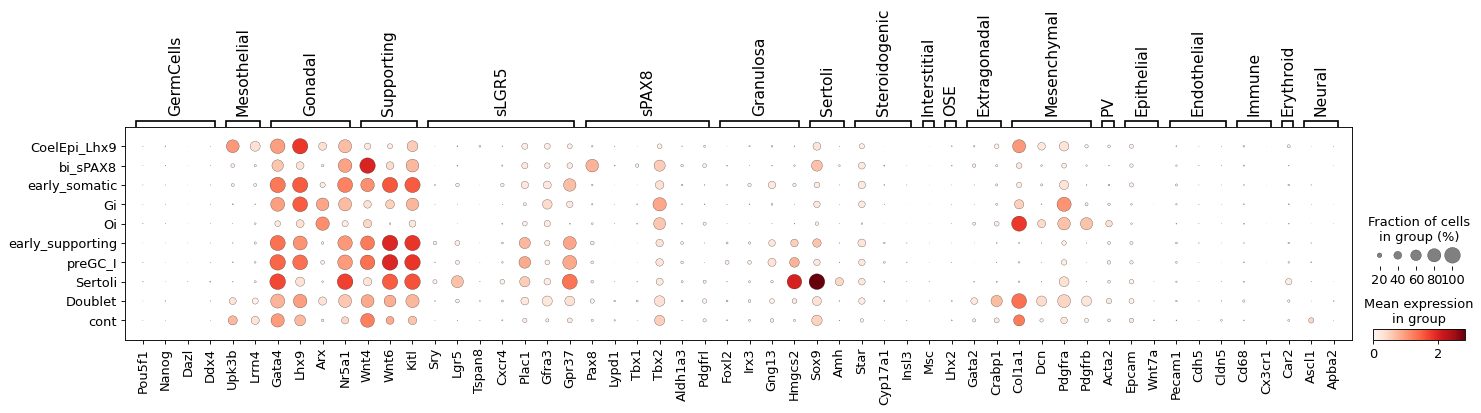

In [66]:
sc.pl.dotplot(adata, marker_genes, groupby='celltype', standard_scale = 'var')
sc.pl.dotplot(adata, marker_genes, groupby='celltype', use_raw=False)

In [67]:
# del adata.obs['celltype_v2']
adata.obs.to_csv(path_to_gonads+'/mouse-gonads_scVI_somatic_annotation.csv')

/opt/conda/envs/scvi-singularity/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'sex_celltype' as categorical


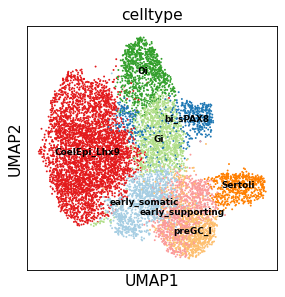

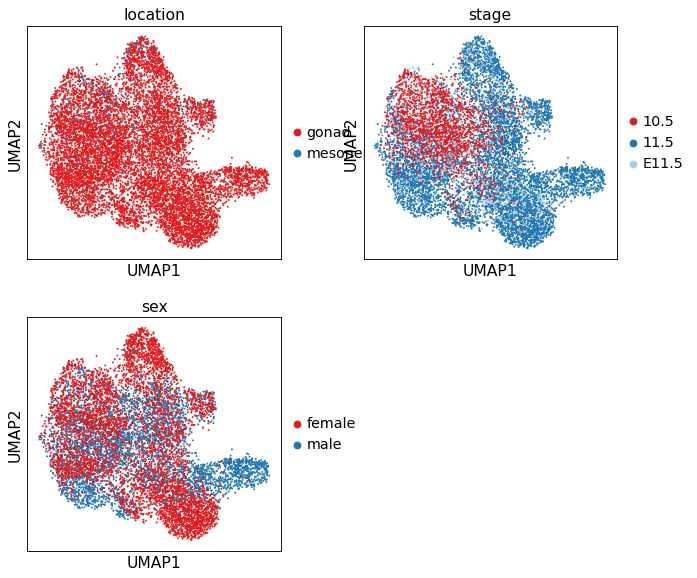

In [74]:
X = adata[[i not in ['Doublet', 'cont'] for i in adata.obs.celltype]]
sc.pl.umap(X, color=['celltype'], ncols = 2, legend_loc='on data', legend_fontsize=8, palette=palette)
sc.pl.umap(X, color=['location', 'stage', 'sex'], ncols = 2, palette=palette)

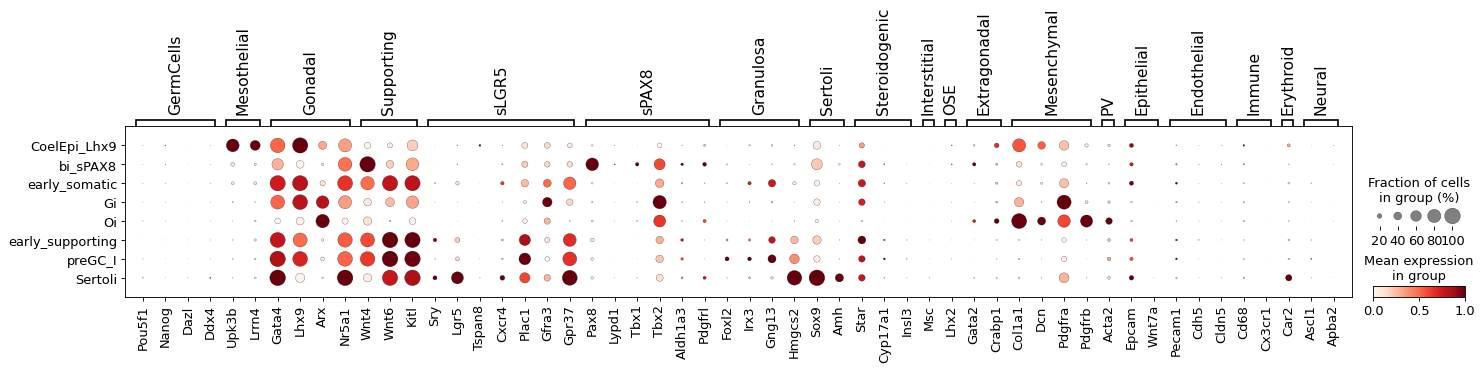

In [75]:
sc.pl.dotplot(X, marker_genes, groupby='celltype', standard_scale = 'var')

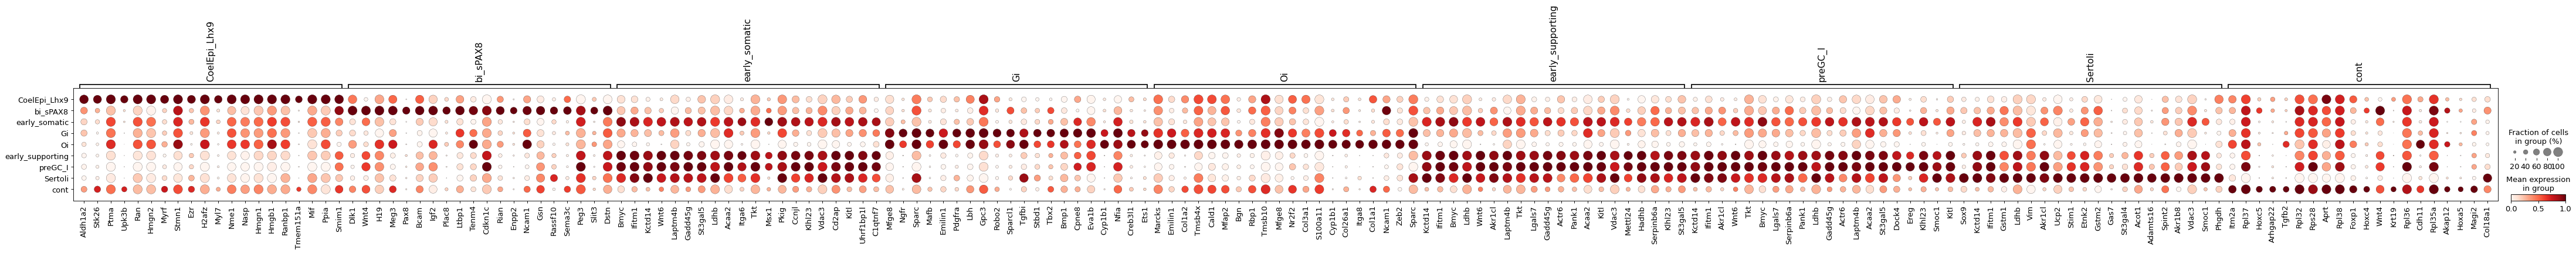

In [70]:
sc.tl.rank_genes_groups(X, groupby='celltype', use_raw=False) #, method='logreg'
sc.pl.rank_genes_groups_dotplot(X, n_genes=20, dendrogram=False, use_raw = False, standard_scale = 'var')

In [71]:
adata.obs['sex_celltype'] = adata.obs.apply(lambda x: '_'.join(x[[ 'celltype', 'sex']]),axis=1)

/opt/conda/envs/scvi-singularity/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'sex_celltype' as categorical


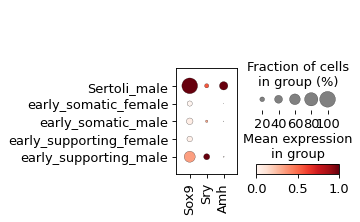

In [72]:
x = adata[[ i in ['Sertoli', 'early_supporting', 'early_somatic'] for i in adata.obs['celltype']]]
sc.pl.dotplot(x[[i not in 'Sertoli_female' for i in x.obs['sex_celltype']]], ['Sox9', 'Sry', 'Amh'], groupby='sex_celltype', standard_scale = 'var')